In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import ahrs
from tabulate import tabulate
from IPython.display import Image, Latex, clear_output
from scipy.spatial.transform import Rotation
from tqdm.auto import tqdm as tqdm
tqdm.pandas(desc="Progress")

In [2]:
# Metadata
header_rows = 3
engine='pyarrow'
input_file = "DATA_2.CSV"

In [3]:
# Load data
df = pd.read_csv(input_file, header=header_rows, engine=engine)

In [4]:
df["_time"] = pd.to_datetime(df["_time"], unit="ms")

In [5]:
data = df[["_time", "_field", "_value"]].set_index(["_time","_field"]).unstack().droplevel(0, axis=1)

In [6]:
data

_field,Acc x,Acc y,Acc z,B,DHT hum,DHT temp,G,Gyro x,Gyro y,Gyro z,Humidity,Intensity,Mag x,Mag y,Mag z,PDM,Pressure,Proximity,R,Temperature
_time,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:05.051,-0.01,-1.01,-0.09,255.0,38.5,26.9,0.0,0.55,0.37,0.37,44.42,255.0,-4.21,85.74,-27.71,-56.25,1014.39,0.0,0.0,27.92
1970-01-01 00:00:05.825,-0.01,-1.01,-0.09,255.0,38.5,26.9,0.0,0.73,0.55,0.37,44.05,255.0,-4.53,85.28,-26.95,-33.50,1011.88,0.0,0.0,28.24
1970-01-01 00:00:06.474,-0.00,-1.01,-0.09,255.0,38.5,26.9,0.0,0.49,0.49,0.31,44.12,255.0,-4.27,85.50,-26.87,-8.25,1014.40,0.0,0.0,28.25
1970-01-01 00:00:07.129,-0.00,-1.01,-0.09,255.0,38.5,26.9,0.0,0.43,0.49,0.31,44.08,255.0,-4.69,86.27,-28.22,-5.75,1014.38,0.0,0.0,28.33
1970-01-01 00:00:07.785,-0.00,-1.01,-0.09,255.0,38.5,26.9,0.0,0.49,0.49,0.37,44.05,255.0,-5.04,85.64,-27.95,-24.25,1014.37,0.0,0.0,28.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 11:00:59.280,-0.01,-1.01,-0.09,255.0,36.5,26.2,0.0,0.49,0.43,0.00,34.93,255.0,-7.02,87.21,-26.97,-13.50,1013.29,0.0,0.0,31.85
1970-01-01 11:00:59.921,-0.01,-1.01,-0.09,255.0,36.5,26.2,0.0,0.61,0.49,0.12,34.91,255.0,-8.22,87.18,-27.47,17.00,1013.30,0.0,0.0,31.87
1970-01-01 11:01:00.567,-0.01,-1.01,-0.09,255.0,36.5,26.2,0.0,0.61,0.43,0.06,34.95,255.0,-8.98,87.24,-27.71,-53.50,1013.26,0.0,0.0,31.80


# IMU

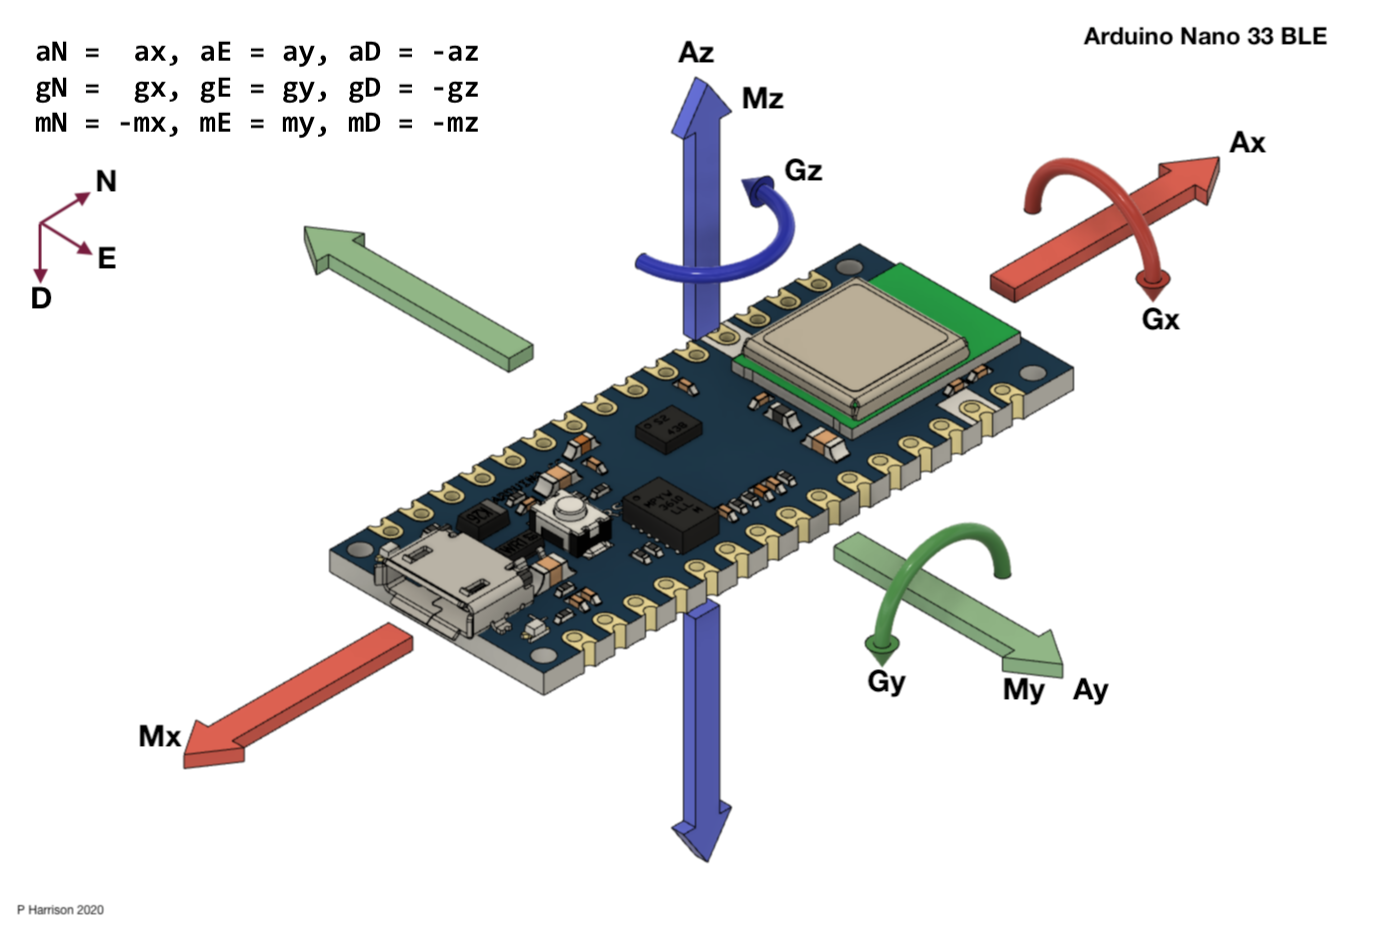

In [7]:
display(Image("Arduino_axis.PNG", retina=True))

Arduino coordinate conversion

Acc & Gyro: (x, y, z)->(y, x, z)

Mag: (x, y, z)->(y, -x, z)

Define right handed base with y pointing forward along the axis originally defined as Ax, x pointing right along the axis originally defined as Ay, and z vertical pointing upwards.

ahrs assumes x points North.

In [8]:
def swap_xy(array):
    array[0], array[1] = array[1], array[0]
    return array

def flip_axis(array, axis):
    array[axis] = -array[axis]
    return array

In [9]:
# Plotting function
def plot_vectors(vectors):
    # Clear the previous plot
    #plt.close()
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection="3d")

    # Define the canonical basis vectors
    basis_vectors = np.identity(3)

    # Plot the basis vectors as lines from the origin
    for basis_vector in basis_vectors:
        ax.quiver(0, 0, 0, basis_vector[0], basis_vector[1], basis_vector[2], color='k', arrow_length_ratio=0.1)
        
    # Extract the vector components
    for i, vector in enumerate(vectors):
        x, y, z = vector

        # Plot the vector as an arrow from the origin
        ax.quiver(0, 0, 0, x, y, z, color='r', arrow_length_ratio=0.1)
        
        # Add an annotation to the tip of the arrow
        ax.text(x, y, z, 'XYZ'[i], color='red')

    # Set labels and limits
    ax.set_xlabel('N')
    ax.set_ylabel('W')
    ax.set_zlabel('Z')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    
    ax.set_box_aspect(None, zoom = 0.9)

    # Display the updated plot
    plt.draw()
    plt.pause(0.1)

# Function to iterate over a list of vectors and display the plot dynamically
def display_vectors_dynamically(vectors):
    def update_plot(index=0):
        plot_vector([vectors[index]])

    widgets.interact(update_plot, index=widgets.IntSlider(min=0, max=len(vectors)-1, step = 1, description='Frame'))

In [10]:
# Vector rotation functions
def compute_rotation(v1, v2):
    # Normalize the input vectors
    v1_norm = v1 / np.linalg.norm(v1)
    v2_norm = v2 / np.linalg.norm(v2)

    # Calculate the axis of rotation
    axis = np.cross(v1_norm, v2_norm)

    # Calculate the angle of rotation
    angle = np.arccos(np.dot(v1_norm, v2_norm))
    
    R = Rotation.from_rotvec(axis*angle, degrees=False)
    
    return R

def update_rotation(gyro, prev_rotation):
    new_rotation = Rotation.from_rotvec(gyro, degrees=False)
    
    # Update rotation matrix using the previous rotation matrix
    updated_rotation = new_rotation * prev_rotation
    
    return updated_rotation


In [70]:
wgs = ahrs.utils.WGS()
madgwick = ahrs.filters.Madgwick()

# Universal constants
lat = 53.48
g = 9.80665

gravity_versor = np.array([0.0, 0.0, -1.0])
gravity_unit = wgs.normal_gravity(lat)
gravity = gravity_versor * gravity_unit/g

# Resolution constants
accelerometer_resolution = 0.122 * 1e-3
gyroscope_resolution = 70 * 1e-3
magnetometer_resolution = 14 * 1e-3

# Calibration constants
initial_rotation = Rotation.identity()
accelerometer_offsets = np.array([0.0, 0.0, 0.0])
gyroscope_offsets = np.array([0.0, 0.0, 0.0])
magnetometer_offsets = np.array([0.0, 0.0, 0.0])

def calibrate_sensors(sensor_data, start = 1, window = 10, plot = False):
    global initial_rotation
    global accelerometer_offsets
    global gyroscope_offsets
    
    begin = sensor_data.index[0]+pd.Timedelta(seconds=start)
    end = begin+pd.Timedelta(seconds=window)
    offsets = sensor_data.loc[begin:end].describe().T
    median_offsets = offsets["50%"]
    median_dt = np.median(np.diff(sensor_data.loc[begin:end].index)/pd.Timedelta(seconds=1))
    offsets["Error"] = offsets["std"]/offsets["mean"]
    print(f"Raw offsets:\n{offsets.to_string()}\n")
    
    raw_accelerometer = median_offsets[["Acc x","Acc y","Acc z"]].to_numpy() # Raw accelerometer readings
    aligned_accelerometer = swap_xy(raw_accelerometer)
    
    raw_gyroscope = median_offsets[["Gyro x","Gyro y","Gyro z"]].to_numpy() # Raw gyroscope readings
    aligned_gyroscope = swap_xy(raw_gyroscope)
    
    raw_magnetometer = median_offsets[["Mag x","Mag y","Mag z"]].to_numpy() # Raw gyroscope readings
    aligned_magnetometer = flip_axis(swap_xy(raw_magnetometer),1)

    print(f"Gyroscope offsets: {gyroscope_offsets} deg/s")
    print(f"Aligned Gyroscope: {aligned_gyroscope} deg/s\n")
    
    print(f"Magnetometer offsets: {magnetometer_offsets} uT")
    print(f"Aligned Magnetometer: {aligned_magnetometer} uT")
    
    initial_rotation = compute_rotation(aligned_accelerometer, gravity_versor)
    rotated_magnetometer = initial_rotation.apply(aligned_accelerometer) * 1e6 # uT -> T to avoid numeric errors
    north_correction = np.arctan(rotated_magnetometer[1]/rotated_magnetometer[0])
    print(f"North correction: {north_correction} rad\n")
    
    initial_rotation = update_rotation(np.array([0,0,1])*north_correction, initial_rotation) # Correct for signal
    print(f"Initial rotation matrix:\n{initial_rotation.as_matrix()}\n")
    # print(f"Initial orientation:\n{initial_rotation.as_quat()}\n")

    inverse_rotated_gravity = initial_rotation.apply(gravity, inverse = True)
    accelerometer_offsets = swap_xy(aligned_accelerometer - inverse_rotated_gravity)
    print(f"Accelerometer offsets: {accelerometer_offsets} g")
    print(f"Aligned Accelerometer: {aligned_accelerometer} g")
    
    if plot:
        plt.matshow(initial_rotation.as_matrix())
        plot_vectors(initial_rotation.as_matrix().T)

In [71]:
def process_sensor_data(sensor_data, start = pd.Timedelta(seconds = 0)):
    position_list = [np.array([0.0, 0.0, 0.0])]  # List to store the calculated positions
    velocity_list = [np.array([0.0, 0.0, 0.0])]
    acceleration_list = [np.array([0.0, 0.0, 0.0])]
    
    start = sensor_data.index[0]+start
    sensor_data = sensor_data.loc[start:]
        
    for idx, (timestamp, row) in enumerate(tqdm(sensor_data.iterrows(), total=sensor_data.shape[0])):
        ax = row["Acc x"]
        ay = row["Acc y"]
        az = row["Acc z"]
        wx = row["Gyro x"]
        wy = row["Gyro y"]
        wz = row["Gyro z"]
        mx = row["Mag x"]
        my = row["Mag y"]
        mz = row["Mag z"]

        acc = np.array([ax, ay, az]) - accelerometer_offsets # Raw acceleration readings
        acc = swap_xy(acc) # Need to swap x and y to form right handed basis
        
        gyro = np.array([wx, wy, wz]) - gyroscope_offsets # Raw gyro readings
        gyro = swap_xy(gyro) # Need to swap x and y to form right handed basis
        gyro = np.radians(gyro)
        
        mag = np.array([mx, my, mz]) - magnetometer_offsets # Raw magnetometer readings
        mag = flip_axis(swap_xy(mag), 1) * 1e-3 # uT -> nT # Need to swap x and y and flip y to form right handed basis
        
        if idx == 0:
            # Initialize first timestamp and rotation matrix
            prev_timestamp = timestamp
            prev_rotation = initial_rotation
            prev_acc = acc
            prev_gyro = gyro
            prev_mag = mag

            continue
        
        if all(abs(acc - prev_acc) < accelerometer_resolution):
            mean_acc = prev_acc
        else:
            mean_acc = (acc + prev_acc) / 2
            prev_acc = acc
            
        if all(abs(gyro - prev_gyro) < gyroscope_resolution):
            mean_gyro = prev_gyro
        else:
            mean_gyro = (gyro + prev_gyro) / 2
            prev_gyro = gyro
             
        if all(abs(mag - prev_mag) < magnetometer_resolution):
            mean_mag = prev_mag
        else:
            mean_mag = (mag + prev_mag) / 2
            prev_mag = mag
        
        # Convert timestamp to time in seconds
        dt = (timestamp - prev_timestamp) / pd.Timedelta(seconds=1)
        prev_timestamp = timestamp
        
        orientation = madgwick.updateMARG(q=prev_rotation.as_quat(), acc=mean_acc, mag=mean_mag, gyr=mean_gyro, dt=dt)
        rotation = Rotation.from_quat(orientation)
        prev_rotation = rotation
        
        # Rotate the linear acceleration vector into the canonical XYZ coordinates
        rotated_acceleration = rotation.apply(mean_acc)
        
        # Remove gravity component from acceleration
        normalized_acceleration = rotated_acceleration - gravity
        acceleration = normalized_acceleration #* gravity_unit #m/s^2
        acceleration_list.append(acceleration)

        # Integrate the rotated linear acceleration to determine velocity
        velocity = np.mean(acceleration_list[-2:], axis=0) * dt + velocity_list[-1]
        velocity_list.append(velocity)

        # Integrate velocity to determine position
        position = np.mean(velocity_list[-2:], axis=0) * dt + position_list[-1]
        position_list.append(position)

    # Create a pandas DataFrame from the positions list
    df_data = np.concatenate((acceleration_list, velocity_list, position_list), axis=1)
    df_columns = [i+j for i in "avp" for j in "xyz"]
    df = pd.DataFrame(df_data, columns = df_columns, index = sensor_data.index)
        
    plot_vectors(rotation.as_matrix().T)
        
    return df

Raw offsets:
             count         mean           std      min        25%       50%        75%      max         Error
_field                                                                                                       
Acc x         76.0    -0.007105  4.565315e-03    -0.01    -0.0100    -0.010     0.0000    -0.00 -6.425259e-01
Acc y         76.0    -1.010000  2.235200e-16    -1.01    -1.0100    -1.010    -1.0100    -1.01 -2.213069e-16
Acc z         76.0    -0.090000  8.382000e-17    -0.09    -0.0900    -0.090    -0.0900    -0.09 -9.313333e-16
B             76.0   255.000000  0.000000e+00   255.00   255.0000   255.000   255.0000   255.00  0.000000e+00
DHT hum       76.0    38.563158  4.855816e-02    38.50    38.5000    38.600    38.6000    38.60  1.259185e-03
DHT temp      76.0    26.927632  4.501462e-02    26.90    26.9000    26.900    27.0000    27.00  1.671689e-03
G             76.0     0.000000  0.000000e+00     0.00     0.0000     0.000     0.0000     0.00           N

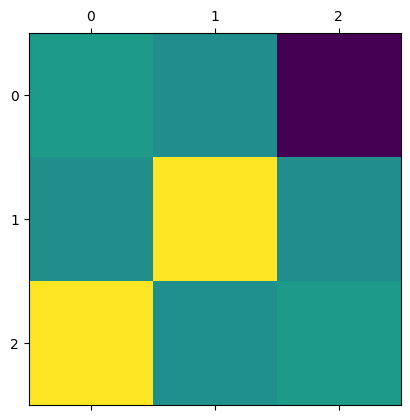

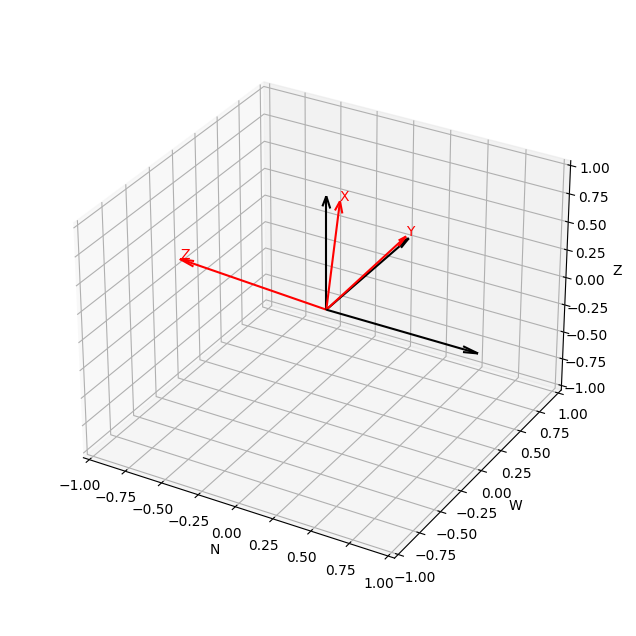

In [72]:
calibrate_sensors(data, window = 50, start = 1, plot=True)

In [73]:
smooth_data = data.rolling(window = 5, min_periods = 1, center = True).median().drop_duplicates()

  0%|          | 0/59814 [00:00<?, ?it/s]

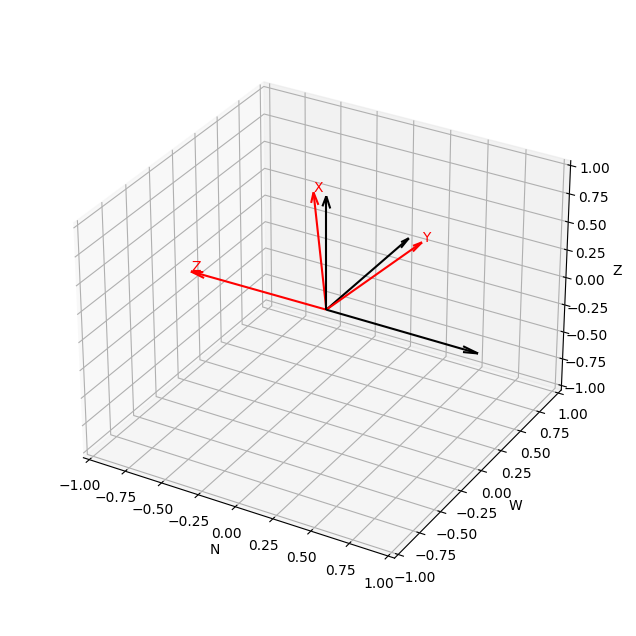

In [74]:
xyz = process_sensor_data(smooth_data, start=pd.Timedelta(seconds=50))
#xyz = process_sensor_data(data, start = pd.Timedelta(seconds=0))

In [75]:
#display_vectors_dynamically(xyz.filter(like="a").values)

## Acceleration

<Axes: xlabel='_time'>

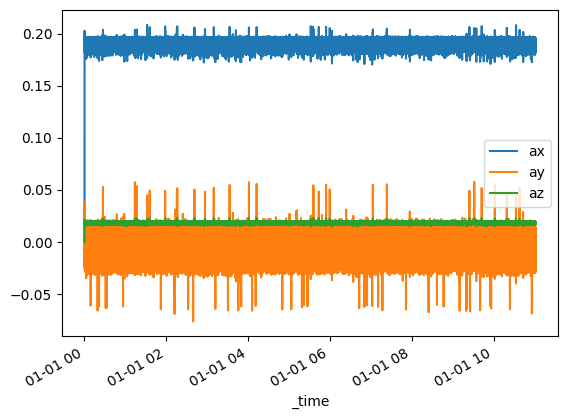

In [76]:
xyz.filter(like="a").plot()

In [18]:
xyz.filter(like="a").mean()

ax    0.191091
ay   -0.005427
az    0.018657
dtype: float64

<Axes: xlabel='_time'>

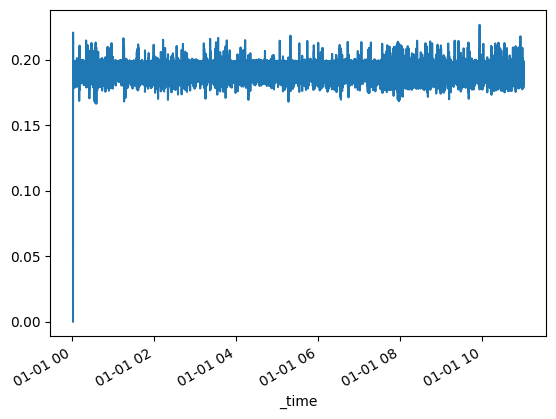

In [19]:
xyz.filter(like="a").apply(np.linalg.norm, axis=1).plot()

## Velocity

<Axes: xlabel='_time'>

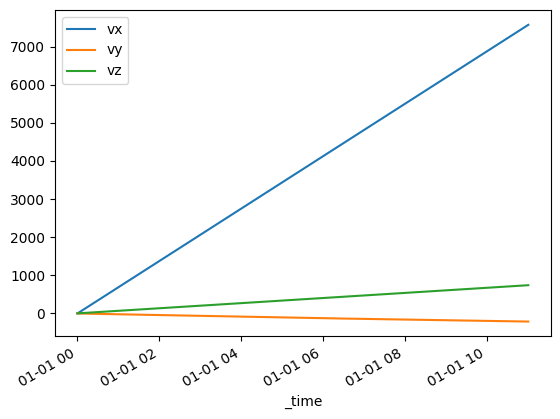

In [20]:
xyz.filter(like="v").plot()

In [21]:
xyz.filter(like="v").sum()

vx    2.261881e+08
vy   -6.762191e+06
vz    2.209528e+07
dtype: float64

## Position

<Axes: xlabel='_time'>

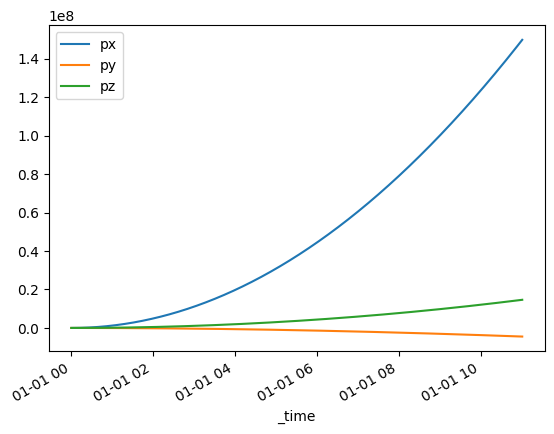

In [22]:
xyz.filter(like="p").plot()

In [23]:
xyz.filter(like="p").sum()

px    2.984763e+12
py   -9.152163e+10
pz    2.916946e+11
dtype: float64

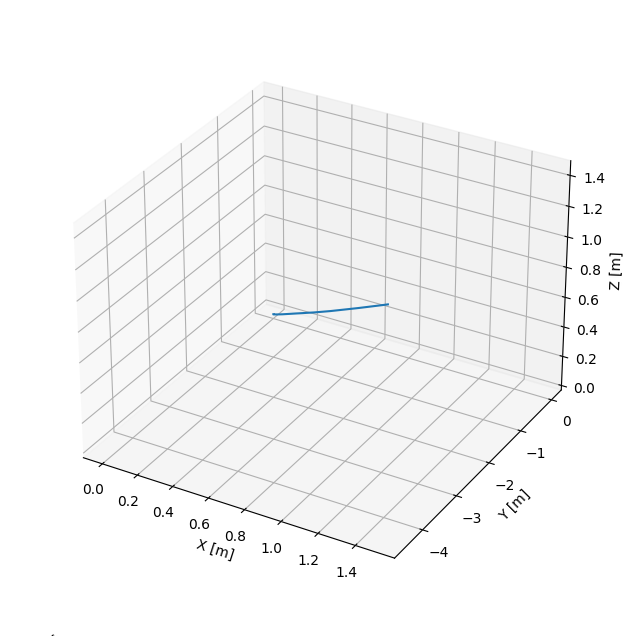

In [24]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(xyz["px"],xyz["py"],xyz["pz"])
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
# ax.set_aspect("equal", adjustable='box')
ax.set_box_aspect(None, zoom = 0.9)
plt.show()

## Raw data 

### Accelerometer

<Axes: xlabel='_time'>

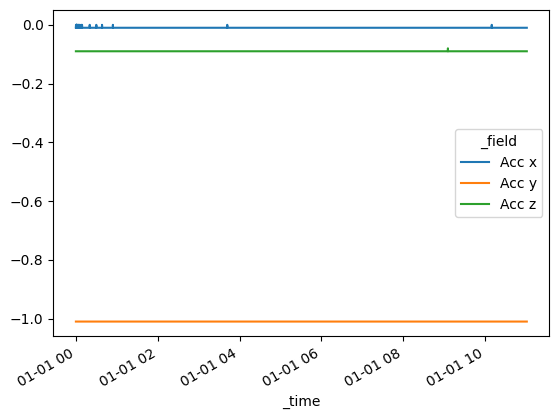

In [25]:
data.filter(like = "Acc ").plot()

<Axes: xlabel='_time'>

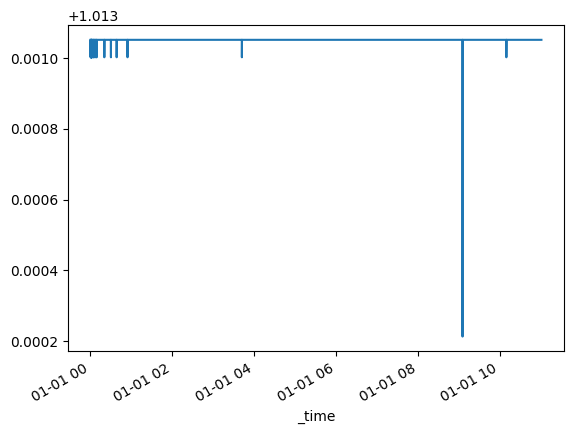

In [26]:
data.filter(like = "Acc").apply(np.linalg.norm, axis=1).plot()

### Gyroscope

<Axes: xlabel='_time'>

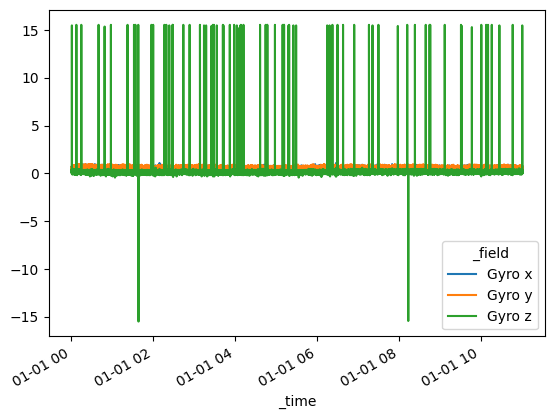

In [27]:
data.filter(like = "Gyro ").plot()

In [28]:
data.filter(like = "Gyro ").mean()

_field
Gyro x    0.577766
Gyro y    0.588527
Gyro z    0.180389
dtype: float64

<Axes: xlabel='_time'>

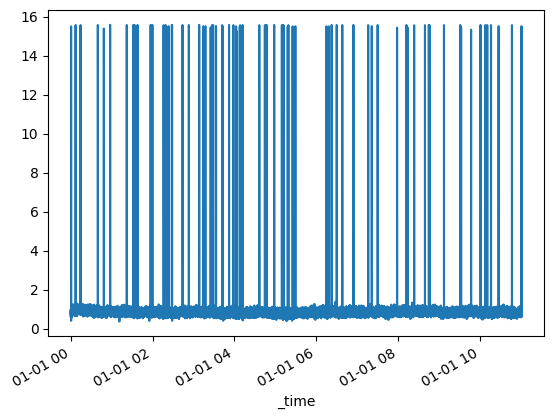

In [29]:
data.filter(like = "Gyro").apply(np.linalg.norm, axis=1).plot()

### Magnetometer

<Axes: xlabel='_time'>

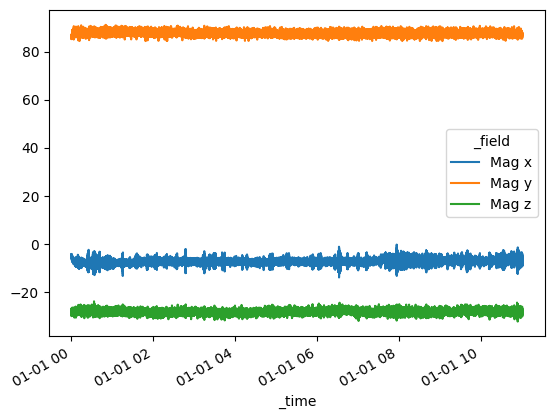

In [30]:
data.filter(like = "Mag").plot()

<Axes: xlabel='_time'>

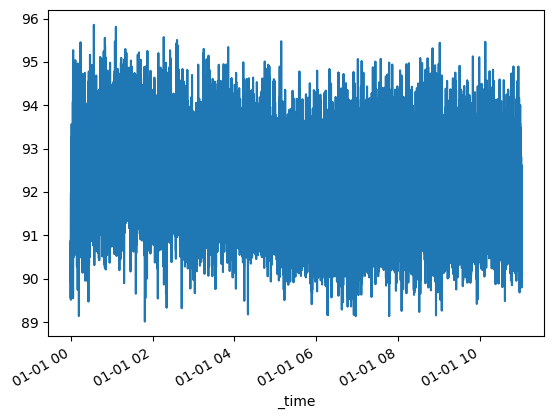

In [31]:
data.filter(like = "Mag").apply(np.linalg.norm, axis=1).plot()